In [49]:
import os
import pandas as pd
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt

In [50]:
data_dir = '/Users/kx/Docs/projects/rhb_gyho/RHB GYHO 2022 Datasets/04. HMW predict which of our customers could become affluent, so that we may retain them'

In [51]:
os.listdir(data_dir)

['sample_prediction_creditcard_txn.txt',
 'sample_prediction_cust_dna.txt',
 'sample_prediction_savingacct_txn.txt',
 'sample_prediction_currentacct_txn.txt',
 'sample_prediction_cust.xlsx',
 'cust_past1year_snapshot.xlsx',
 'AffluentPrediction_DataDictionary.xlsx',
 'AffluentPrediction_DataDictionary_raw.xlsx',
 'sample_prediction_cust_v1.xlsx',
 '~$AffluentPrediction_DataDictionary.xlsx']

### Read data

In [5]:
fname = os.path.join(data_dir, 'AffluentPrediction_DataDictionary_raw.xlsx')
sheet_names = ['cust', 'creditcard_txn', 'currentacct_txn', 'savingacct_txn', 'cust_dna']

# read descs
descs = []
for sheet_name in sheet_names:
    desc = pd.read_excel(fname, sheet_name=sheet_name)
    desc['df'] = sheet_name
    descs.append(desc)

desc_full = pd.concat(descs)

stemmer = SnowballStemmer("english")
desc_full['desc_clean'] = desc_full['Description'] \
    .str.lower() \
    .str.replace('[^a-z]', ' ', regex=True) \
    .apply(lambda x: ' '.join([stemmer.stem(y) for y in x.split(' ')]))

# read dfs
df_names = [
    ('cust', None), ('creditcard_txn', '\t'), ('currentacct_txn', '\t'), 
    ('savingacct_txn', '\t'), ('cust_dna', '|')
]
dfs = {}
for df_name, delim in df_names:
    fname = 'sample_prediction_{}.txt'.format(df_name)
    if fname in os.listdir(data_dir):
        dfs[df_name] = pd.read_csv(os.path.join(data_dir, fname), delimiter=delim)
    else:
        fname = fname.replace('.txt', '.xlsx')
        dfs[df_name] = pd.read_excel(os.path.join(data_dir, fname))

# tidy affluent columns
target_cols = dfs['cust'].columns[pd.Series(dfs['cust'].columns).str.contains('be_segment')]
dfs['cust'].loc[:, target_cols] = dfs['cust'][target_cols].apply(lambda x: x.str[0])
dfs['cust'].loc[:, target_cols] = dfs['cust'][target_cols].fillna('-1').astype('int')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Variable descriptions

In [6]:
# word freq
desc_word_freq = pd.value_counts(' '.join(desc_full['desc_clean']).split(' '))
desc_word_freq
# desc_word_freq.to_csv('word_freq.csv')

# word dict
desc_dict = set(desc_word_freq.index)
desc_dict

{'',
 'a',
 'abbrevi',
 'abov',
 'absolut',
 'acc',
 'account',
 'activ',
 'ad',
 'addit',
 'after',
 'age',
 'aggreg',
 'ai',
 'all',
 'amanah',
 'amip',
 'amount',
 'amt',
 'an',
 'and',
 'ani',
 'annual',
 'app',
 'applic',
 'are',
 'arrahnu',
 'as',
 'asb',
 'asnb',
 'asset',
 'assign',
 'assur',
 'aum',
 'auto',
 'averag',
 'balanc',
 'bancassur',
 'bancasurr',
 'band',
 'bank',
 'base',
 'been',
 'befor',
 'benchmark',
 'berhad',
 'blacklist',
 'blue',
 'bond',
 'both',
 'branch',
 'brd',
 'brh',
 'but',
 'buy',
 'by',
 'ca',
 'card',
 'casa',
 'cash',
 'cashback',
 'cashlin',
 'categori',
 'cbpa',
 'cert',
 'channel',
 'charg',
 'chines',
 'choos',
 'citizen',
 'close',
 'cn',
 'code',
 'collater',
 'convent',
 'conventionalfix',
 'corpor',
 'count',
 'counter',
 'countri',
 'coverag',
 'credit',
 'currenc',
 'current',
 'custom',
 'cut',
 'data',
 'date',
 'day',
 'dcp',
 'debit',
 'debt',
 'decreas',
 'defin',
 'degre',
 'denot',
 'depend',
 'deposit',
 'descript',
 'detail',


In [25]:
tags = [
    'loan',
    '([^x] +deposit acc)|(^deposit acc)',
    '(fd)|(fix deposit)',
    '(insur)|(premium)', '(bancassur)|(bancasurr)',
    'invest',
    'credit card', 'debit card',
    'islam', 'convent',
    'revenu',
    'financ',
    'polici',
    'hire purchas',
    'debit t', 'credit t',
    '( ut )|(^ut )|( ut$)|(unit trust)',
    'mortgag', 'hous', 'properti',
    'casa', 'save', 'current',
    'overdraft acc', 'internet bank acc', 'arrahnu',
    'asset',
    'withdraw',
    'onlin',
    'debt',
    'outstand'
]

In [40]:
tmp = tags + ['(od )|( od)|( od )', '(sa )|( sa)|( sa )', '(ca )|( ca)|( ca )',
              'month', 'transact', 'segment', 'asb', 'desc']
s = '({})'.format(')|('.join(tmp))
list(desc_full[~desc_full['desc_clean'].str.contains(s)]['Description'])

tmp = desc_full[~desc_full['desc_clean'].str.contains(s)]
list(zip(tmp['df'], tmp['Variable'], tmp['Description']))

[('cust', 'id', 'customer number'),
 ('cust', 'FRST_CONT_DT', 'date when customer first join the bank'),
 ('cust', 'CUST_AGE', "customer's age "),
 ('cust', 'RACE', "customer's race"),
 ('cust', 'SEX', 'customer gender'),
 ('cust', 'MARITAL_STATUS', 'customer marital status'),
 ('cust', 'D_OCC', 'customer occupation code'),
 ('cust',
  'DOMICILE_BR_CODE',
  "Branch code of customer's first account opened"),
 ('cust',
  'DOMICILE_BR_NAME',
  "Branch name of customer's first account opened"),
 ('cust',
  'DOMICILE_BR_REGION',
  "Branch region of customer's first account opened"),
 ('cust',
  'BE_MCA',
  'customer hold Multi-Currency Account?\nVar= 1 if the customer holds Multi-Currency Account\nvar=0 if the customer does not have Multi-Currency Account'),
 ('cust',
  'BE_MCA_CNT',
  'total number of Multi-Currency accounts owned by customer'),
 ('cust', 'BE_MCA_BAL', 'customer Multi-Currency Account balance'),
 ('cust',
  'BE_RBOND',
  'customer hold Retail Bond account?\nVar= 1 if the c

In [48]:
s = 't month'
desc_full[desc_full['desc_clean'].str.contains(s)]['Variable'].tolist()[:-2]

['DP_A6M_CASA_MTHLY_WDR_CNT',
 'DP_A6M_CASA_MTHLY_WDR_AMT',
 'DP_R6M_CASA_MTHLY_WDR2DEP_AMT',
 'DP_L6M_SLP_CASA_MTHLY_WDR_AMT',
 'DP_A6M_FD_MTHLY_WDR_CNT',
 'DP_A6M_FD_MTHLY_WDR_AMT',
 'DP_R6M_FD_MTHLY_WDR2DEP_AMT',
 'DP_L6M_SLP_FD_MTHLY_WDR_AMT']

In [115]:
tmp = '({})'.format(')|('.join(tags))
desc_full[~desc_full['desc_clean'].str.contains(tmp)]
desc_full[desc_full['Variable'].str.lower().str.contains('segment')]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Variable,Type,Len,Format,Informat,Description,df,desc_clean
0,id,Num,8,NaN,NaN,customer number,cust,custom number
1,FRST_CONT_DT,Num,8,DDMMYY10.,NaN,date when customer first join the bank,cust,date when custom first join the bank
2,CUST_AGE,Num,8,NaN,NaN,customer's age,cust,custom s age
3,RACE,Char,100,NaN,NaN,customer's race,cust,custom s race
4,SEX,Char,15,15,NaN,customer gender,cust,custom gender
...,...,...,...,...,...,...,...,...
262,ASB_MTHEND_BAL_M2,Num,8,NaN,NaN,ASB MONTH END BALANCE AS OF THE T-1 MONTH,cust_dna,asb month end balanc as of the t month
263,ASB_MTHEND_BAL_M3,Num,8,NaN,NaN,ASB MONTH END BALANCE AS OF THE T-2 MONTH,cust_dna,asb month end balanc as of the t month
264,ASB_MTHEND_BAL_M4,Num,8,NaN,NaN,ASB MONTH END BALANCE AS OF THE T-3 MONTH,cust_dna,asb month end balanc as of the t month
265,ASB_MTHEND_BAL_M5,Num,8,NaN,NaN,ASB MONTH END BALANCE AS OF THE T-4 MONTH,cust_dna,asb month end balanc as of the t month


In [7]:
sum(dfs['creditcard_txn']['D_TRANSACTION_MODE'].isna())/ dfs['creditcard_txn'].shape[0]

0.6799186662295272

In [69]:
dfs['cust_dna']['cd_active_cust_flg'].sum()

9985.0

In [59]:
set(dfs['currentacct_txn']['D_PAYMENT_DETAILS'])

{nan,
 'cut grass n trees 69',
 '889MA4U122108092231Y',
 'MY CARD 8644',
 '8B2HMAP122111021012Y',
 '3/2021',
 '8CDGMYC4CA2112062309',
 '89EPRS1422109141131Y',
 '89K4SRW322109201302Y',
 'dididen01',
 'FD 1 of 5',
 'Apr21 Statement',
 'clear cheque 4k',
 'NovFee',
 '83920XU722103090821Y',
 '86TRWGN322106281148Y',
 'Refund of Adv',
 'Topglove',
 'OXIMETER-TEST KIT',
 'uf9770',
 'down payment composi',
 'No16A IE4 - Dec 2021',
 '89AISXTK22109101633Y',
 'attires n shoes',
 '3868',
 '7999067',
 '8CDELY9422112130827Y',
 '88P7SM0822108241407Y',
 'Hire Purchase VGB378',
 'Yi En TuitionFees',
 '83BNHI0Y22103111125Y',
 '0036',
 'Cny New notes',
 'Tiri',
 '83MA5SJQ22103221053N',
 'OWN CAPITAL',
 '006770759602',
 'Turtle Emily BD',
 '8AUFT3SR22110291057Y',
 '8BPJC8W222111240851Y',
 'HL#31(Aug 2021)',
 '8BQ0ER9622111251102Y',
 'HSBC NOV 2021',
 'Director allowance',
 'Oct Salary',
 'bayo utang',
 'Kong Jun Zhe',
 'Vicki Chew',
 'Falim Sports Centre1',
 'Pymnt bungkusit',
 'PAYMENT FOR INSURANC',
 't

Merch

In [447]:
tmp = dfs['creditcard_txn'].groupby('MERCH_CATEGORY').count()[['id']].sort_values('id', ascending=False)
merch_cat= tmp.index[24]
print(merch_cat)
set(dfs['creditcard_txn'][dfs['creditcard_txn']['MERCH_CATEGORY'] == merch_cat]['TRAN_DESC_DETAIL'])

5722.0


{'#SINCERE ZONE ELECTRONICSCHERAS       MY',
 '4 SMART PLUS             KAJANG       MY',
 'A.E.S SALES & SERVICES-HQMASAI        MY',
 'AI HOME-PJ               PETALING JAYAMY',
 'AIFA ELECTRICAL M S/B    W P LABUAN   MY',
 'ARDENT                   339-3684589  US',
 'ASAKI                    JOHOR BAHRU  MY',
 'BACFREE WATER-HQ         SELANGOR     MY',
 'BACFREE WATER-SUBANG     SELANGOR     MY',
 'BAN HIN BEE ANSON ROAD   PENANG       MY',
 'BAN HIN BEE SB           PENANG       MY',
 'BAN HIN BEE VANTAGE      PENANG       MY',
 'BAN HIN BEE VANTAGE PO   JELUTONG     MY',
 'BAN HIN BEE-IDEAL AVEN   BAYAN LEPAS  MY',
 'BAN HIN BEE-SWY WELLESLEYPENANG       MY',
 'BBQ BANGSAR VILLAGE      KUALA LUMPUR MY',
 'BBQ KING IKANO           PETALING JAYAMY',
 'BEST POINT-CHAI LENG P   PENANG       MY',
 'BEST POINT-TANJUNG TOKONGPENANG       MY',
 'BESTPOINT BKT MERTAJAM   BKT. MERTAJAMMY',
 'BESTPOINT PERAI          PERAI        MY',
 'BESTPOINT SERAYA INDAH   KULIM        MY',
 'BH 11 HO

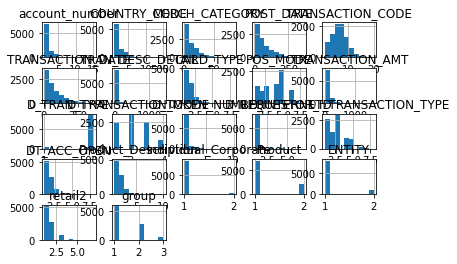

In [380]:
tmp = dfs['creditcard_txn'].groupby('id').nunique(dropna=False)
_ = tmp.hist()

In [361]:
desc_full.groupby('df').count()

,Variable,Type,Len,Format,Informat,Description,desc_clean
df,,,,,,,
creditcard_txn,23,23,23,21,21,23,23
currentacct_txn,34,34,34,28,27,34,34
cust,189,189,189,10,3,189,189
cust_dna,267,267,267,16,2,267,267
savingacct_txn,33,33,33,27,27,33,33


In [352]:
!mkdir data

In [353]:
for x in dfs:
    dfs[x].to_csv('data/' + x + '.csv', index=False)


### be_segment columns

In [346]:
(dfs['cust'][target_cols] == -1).sum()

be_segment_p12m    354
be_segment_p11m    304
be_segment_p10m    264
be_segment_p9m     208
be_segment_p8m     174
be_segment_p7m     135
be_segment_p6m     112
be_segment_p5m     100
be_segment_p4m      83
be_segment_p3m      49
be_segment_p2m      15
dtype: int64

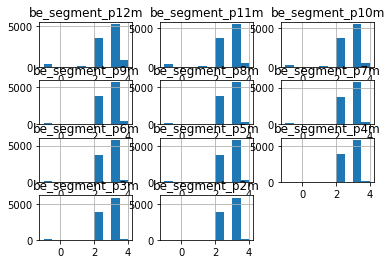

In [348]:
_ = dfs['cust'][target_cols].hist()

In [102]:
dfs['cust'][target_cols].replace(-1, None)

,be_segment_p12m,be_segment_p11m,be_segment_p10m,be_segment_p9m,be_segment_p8m,be_segment_p7m,be_segment_p6m,be_segment_p5m,be_segment_p4m,be_segment_p3m,be_segment_p2m
0,2,2,2,2,2,2,2,2,2,2,2
1,2,2,2,2,2,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,2
4,4,4,4,4,4,4,4,4,3,2,2
...,...,...,...,...,...,...,...,...,...,...,...
9995,3,3,3,3,3,3,3,3,3,3,3
9996,3,3,3,3,3,3,3,3,3,3,3
9997,2,2,2,2,2,2,2,2,2,2,2
9998,3,3,3,3,3,3,3,3,3,3,3


In [114]:
dfs['savingacct_txn'][dfs['savingacct_txn']['id'] == 25921031]['MOB']

901225    4.0
901226    4.0
901227    4.0
901228    4.0
901229    4.0
901230    4.0
901231    4.0
901232    4.0
901233    4.0
901234    4.0
901235    4.0
Name: MOB, dtype: float64